In [ ]:
from google.colab import files
files.upload()   # upload kaggle.json here

In [2]:
!mkdir -p ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d nirmalsankalana/rice-leaf-disease-image

Dataset URL: https://www.kaggle.com/datasets/nirmalsankalana/rice-leaf-disease-image
License(s): CC0-1.0
 66% 128M/195M [00:00<00:00, 1.34GB/s]
100% 195M/195M [00:00<00:00, 917MB/s] 


In [9]:
!unzip -q rice-leaf-disease-image.zip -d rice_leaf_disease

In [10]:
import os

data_dir = "/content/rice_leaf_disease"
print(os.listdir(data_dir))

['Brownspot', 'Blast', 'Bacterialblight', 'Tungro']


In [11]:
import tensorflow as tf

# Path to dataset
data_dir = "/content/rice_leaf_disease"

# Step 1: Create Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Step 2: Create Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Step 3: Print class names
class_names = train_ds.class_names
print("Class Names:", class_names)

Found 5932 files belonging to 4 classes.
Using 4746 files for training.
Found 5932 files belonging to 4 classes.
Using 1186 files for validation.
Class Names: ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


In [12]:
class_counts = {}
for images, labels in train_ds.unbatch():
    label = int(labels.numpy())
    class_counts[label] = class_counts.get(label, 0) + 1
print("Counts per class:", class_counts)

Counts per class: {2: 1269, 3: 1038, 0: 1296, 1: 1143}


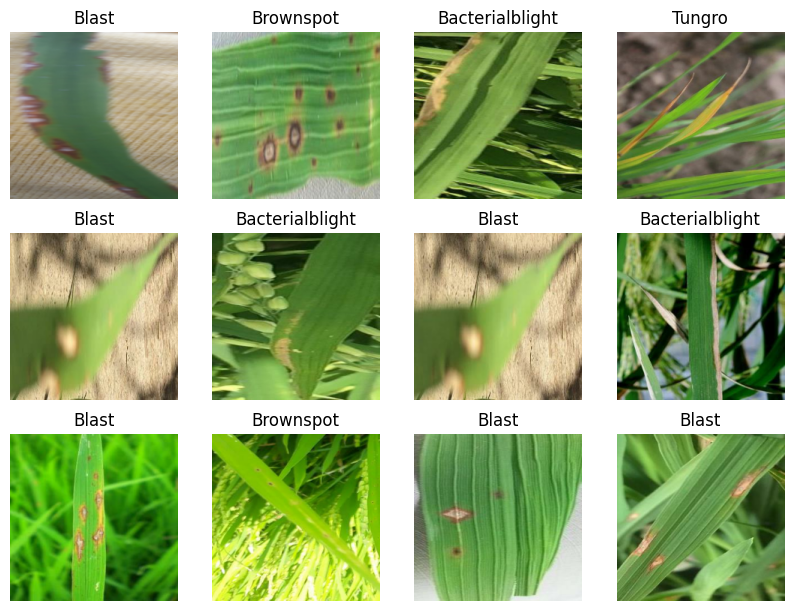

In [14]:
import matplotlib.pyplot as plt

# Visualize some training images
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
# Step 1: AUTOTUNE lets TensorFlow tune performance automatically
AUTOTUNE = tf.data.AUTOTUNE

# Step 2: Optimize train and validation datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
for images, labels in train_ds.take(1):
    print(labels[:10].numpy())

[2 3 2 2 2 1 1 2 2 2]


In [17]:
# Confirm pixel values are still 0–255 (not normalized yet)
for images, labels in train_ds.take(1):   # take one batch
    print("Pixel range (min, max):", images.numpy().min(), images.numpy().max())
    print("Example pixel value:", images[0][0][0].numpy())

Pixel range (min, max): 0.0 255.0
Example pixel value: [177.25693 177.25693 177.25693]


In [18]:
from tensorflow import keras
from tensorflow.keras import layers

# Step 1: Build CNN Model
model = keras.Sequential([
    # Input Layer: normalize pixel values
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    # Convolution + Pooling Block 1
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    # Convolution + Pooling Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    # Convolution + Pooling Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    # Flatten feature maps → Dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # prevent overfitting

    # Output layer (3 classes)
    layers.Dense(len(class_names), activation='softmax')
])

# Step 2: Compile model
model.compile(
    optimizer='adam',                        # Adam optimizer (fast + adaptive)
    loss='sparse_categorical_crossentropy',  # since labels are integer encoded
    metrics=['accuracy']                     # track accuracy
)

# Step 3: Model summary
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [20]:
# Step 1: Train model
history = model.fit(
    train_ds,                # training dataset
    validation_data=val_ds,  # validation dataset
    epochs=100,               # number of passes through dataset
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.4717 - loss: 1.2346 - val_accuracy: 0.7816 - val_loss: 0.5919
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.7879 - loss: 0.5891 - val_accuracy: 0.8575 - val_loss: 0.3748
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8807 - loss: 0.3143 - val_accuracy: 0.9351 - val_loss: 0.2176
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9426 - loss: 0.1920 - val_accuracy: 0.9191 - val_loss: 0.2363
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9634 - loss: 0.1239 - val_accuracy: 0.9739 - val_loss: 0.0818
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9749 - loss: 0.0682 - val_accuracy: 0.9612 - val_loss: 0.0960
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9835 - loss: 0.0516 - val_accuracy: 0.9494 - val_loss: 0.1749
Epoch 8/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9818 - loss: 0.0

In [21]:
import numpy as np

# Index of best validation loss
best_epoch = np.argmin(history.history['val_loss'])
print("Epoch with lowest validation loss (best weights):", best_epoch+1)

# Corresponding validation accuracy
print("Validation accuracy at best epoch:", history.history['val_accuracy'][best_epoch])

Epoch with lowest validation loss (best weights): 9
Validation accuracy at best epoch: 0.9890387654304504


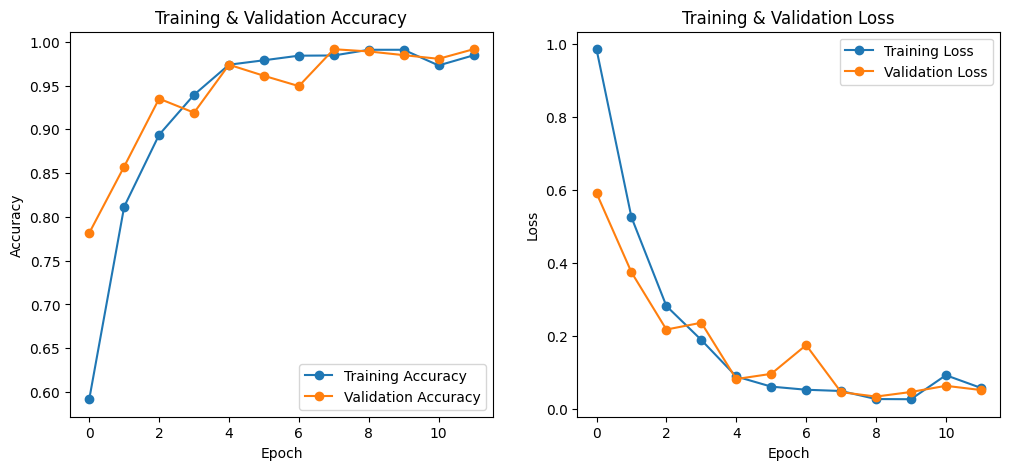

In [22]:
import matplotlib.pyplot as plt

# Extract accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, marker='o', label='Training Accuracy')
plt.plot(epochs_range, val_acc, marker='o', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, marker='o', label='Training Loss')
plt.plot(epochs_range, val_loss, marker='o', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [23]:
# Step 6.1: Evaluate model on validation dataset
val_loss, val_acc = model.evaluate(val_ds, verbose=1)

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9852 - loss: 0.0400
Validation Accuracy: 0.9890
Validation Loss: 0.0337


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


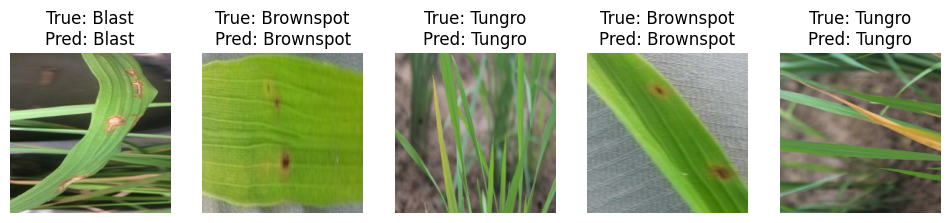

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


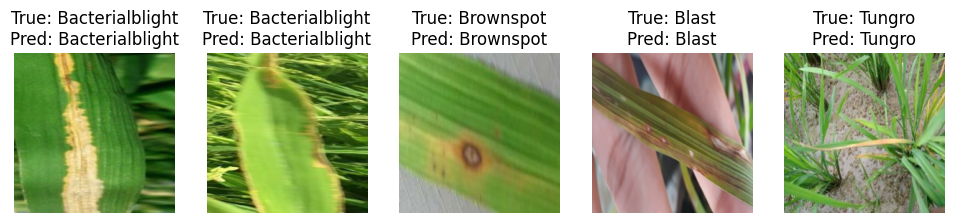

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


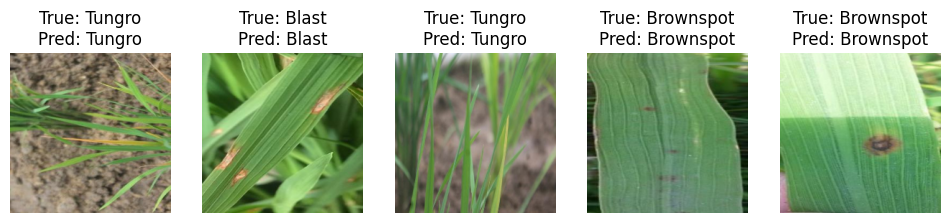

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Step 6.2: Take a batch from validation dataset
for images, labels in val_ds.take(3):
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    # Plot first 5 images with predictions
    plt.figure(figsize=(12, 6))
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[pred_classes[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.show()

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Step 1: Collect true and predicted labels (already done)
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    pred_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

# Step 2: Generate confusion matrix (raw numbers)
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix (rows = true labels, cols = predicted labels):")
print(cm)

Confusion Matrix (rows = true labels, cols = predicted labels):
[[285   1   2   0]
 [  2 290   0   5]
 [  0   1 330   0]
 [  2   0   0 268]]


<Figure size 800x600 with 0 Axes>

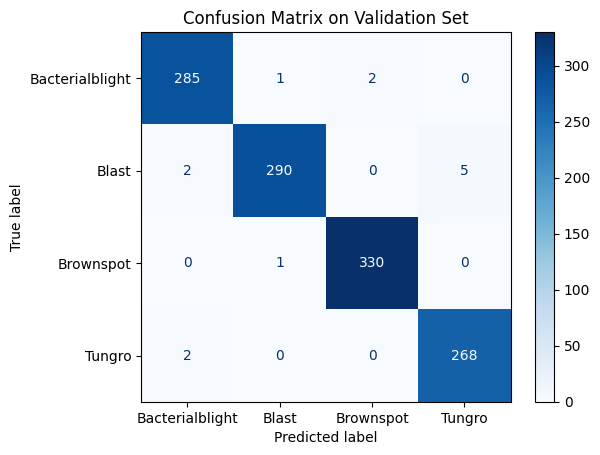

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Step 3: Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

Bacterialblight       0.99      0.99      0.99       288
          Blast       0.99      0.98      0.98       297
      Brownspot       0.99      1.00      1.00       331
         Tungro       0.98      0.99      0.99       270

       accuracy                           0.99      1186
      macro avg       0.99      0.99      0.99      1186
   weighted avg       0.99      0.99      0.99      1186



In [29]:
model.save("rice_disease_model.keras")

In [30]:
from google.colab import files

# Download saved model
files.download("/content/rice_disease_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import shutil

# Zip the unzipped dataset folder
shutil.make_archive("/content/rice_leaf_disease", 'zip', "/content/rice_leaf_disease")

# Download the zipped folder
files.download("/content/rice_leaf_disease.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>